#### To be executed in google collab

In [1]:
#Load files to current environment from https://drive.google.com/open?id=1Z2i1iVsC87cHEV0bo1MIJhPXfMTulP9P
#https://enmilocalfunciona.io/tratamiento-de-imagenes-usando-imagedatagenerator-en-keras/
#https://theailearner.com/2019/07/06/imagedatagenerator-flow_from_directory-method/

In [63]:
!git clone https://github.com/Angeluz-07/web-ui-evaluator.git

fatal: destination path 'web-ui-evaluator' already exists and is not an empty directory.


In [64]:
import numpy as np # linear algebra
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
import csv

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import densenet
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K
from keras import losses
from keras import optimizers
import keras

print(tf.__version__)

2.15.0


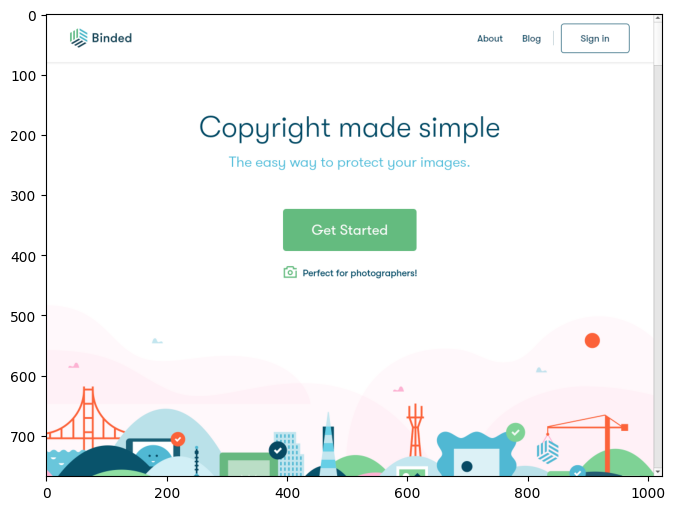

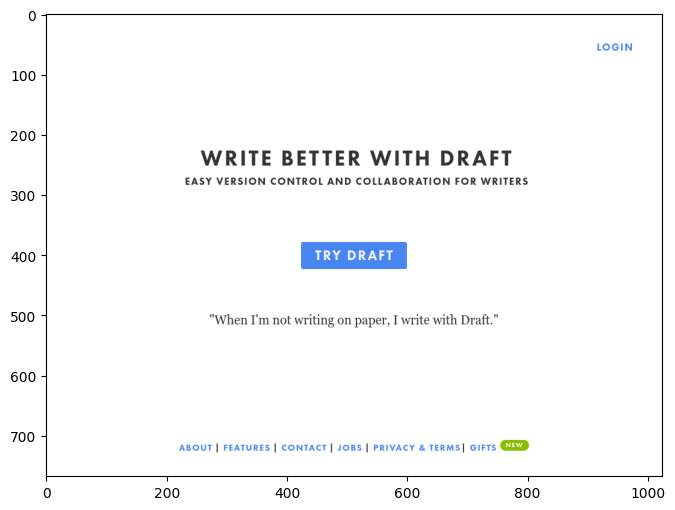

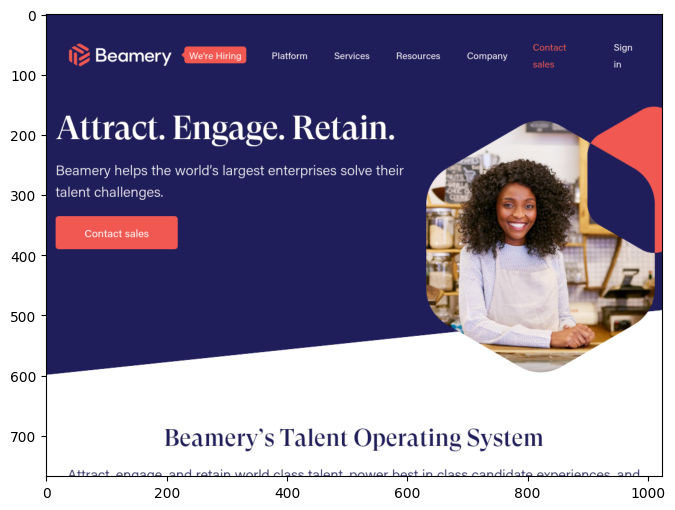

In [65]:
data_path_base = 'web-ui-evaluator/dataset/v2'

image = Image.open(data_path_base + '/appealing_constrast/wss_227.png')
plt.figure(0)
imgplot = plt.imshow(image)

image = Image.open(data_path_base + '/minimalist/wss_160.png')
plt.figure(1)
imgplot = plt.imshow(image)

image = Image.open(data_path_base + '/visual_load/wss_159.png')
plt.figure(2)
imgplot = plt.imshow(image)

plt.show()

In [66]:
data_path_base = 'web-ui-evaluator/dataset/v2'
img_width, img_height = 1024//2, 768//2
batch_size = 32
print(img_width, img_height)

512 384


In [76]:
train_data_dir = data_path_base

train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.2,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data


Found 285 images belonging to 3 classes.
Found 70 images belonging to 3 classes.


In [8]:
# checking one image
a = train_generator.next()
print(a[0].shape)
image = tf.keras.preprocessing.image.load_img(data_path_base + '/appealing_constrast/wss_227.png')
input_arr = keras.preprocessing.image.img_to_array(image)
input_arr.shape

(32, 384, 512, 3)


(768, 1024, 3)

In [77]:
#https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
def F1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [83]:

def create_model():

  model = Sequential()
  model.add(Conv2D(64, (5,5), input_shape = (img_height,img_width,3)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(5,5)))

  model.add(Conv2D(128, (4,4)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(4,4)))

  model.add(Conv2D(256, (3,3)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(3,3)))

  model.add(Flatten())

  model.add(Dense(3))
  model.add(Activation('sigmoid'))

  model.summary()
  model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['acc'])

  return model

#71%
def create_modelv2():

  base_model = keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height,img_width,3),
    pooling='avg',
    include_top=False)  # Do not include the ImageNet classifier at the top.
  base_model.trainable = False

  model = keras.Sequential([
      base_model,
      keras.layers.Dense(128),
      keras.layers.Dense(32),
      keras.layers.Dense(3, activation='sigmoid')
  ])

  model.summary()

  opt = keras.optimizers.Adam(learning_rate=0.0005)
  model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['acc',F1])

  return model

In [84]:
model = create_model()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 380, 508, 64)      4864      
                                                                 
 activation_24 (Activation)  (None, 380, 508, 64)      0         
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 76, 101, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 73, 98, 128)       131200    
                                                                 
 activation_25 (Activation)  (None, 73, 98, 128)       0         
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 18, 24, 128)       0         
 ng2D)                                                

In [85]:
tf.random.set_seed(0)

In [86]:
checkpoint_filepath = 'model-{epoch:03d}-{val_acc:03f}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

In [87]:
EPOCHS = 100
model_history=model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = EPOCHS,
    callbacks=[model_checkpoint_callback])

Epoch 1/100
8/8 [==============================] - 28s 4s/step - loss: 0.6552 - acc: 0.3478 - val_loss: 0.6179 - val_acc: 0.3750
Epoch 2/100
8/8 [==============================] - 29s 4s/step - loss: 0.6043 - acc: 0.4862 - val_loss: 0.5641 - val_acc: 0.5781
Epoch 3/100
8/8 [==============================] - 29s 4s/step - loss: 0.6149 - acc: 0.4071 - val_loss: 0.6049 - val_acc: 0.4375
Epoch 4/100
8/8 [==============================] - 25s 3s/step - loss: 0.6256 - acc: 0.4308 - val_loss: 0.5998 - val_acc: 0.4844
Epoch 5/100
8/8 [==============================] - 29s 4s/step - loss: 0.5990 - acc: 0.4822 - val_loss: 0.5750 - val_acc: 0.5156
Epoch 6/100
8/8 [==============================] - 29s 4s/step - loss: 0.5817 - acc: 0.4901 - val_loss: 0.6770 - val_acc: 0.3906
Epoch 7/100
8/8 [==============================] - 28s 4s/step - loss: 0.6040 - acc: 0.4648 - val_loss: 0.5484 - val_acc: 0.5469
Epoch 8/100
8/8 [==============================] - 28s 4s/step - loss: 0.6134 - acc: 0.4190 - val

In [88]:
max(model_history.history['val_acc'])

0.703125

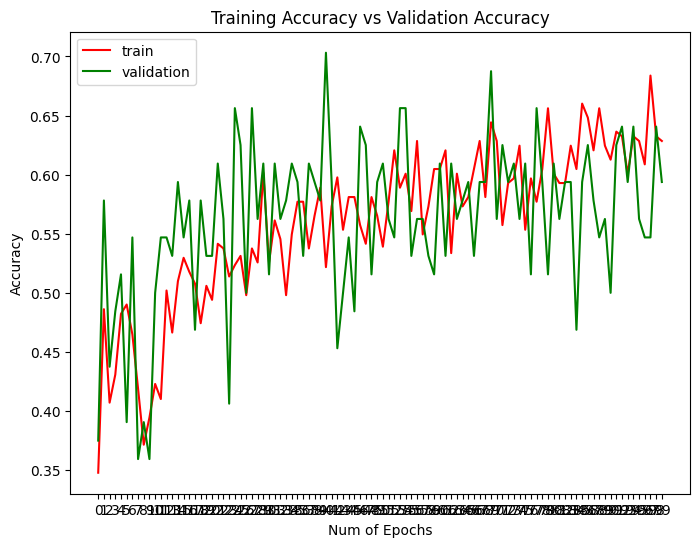

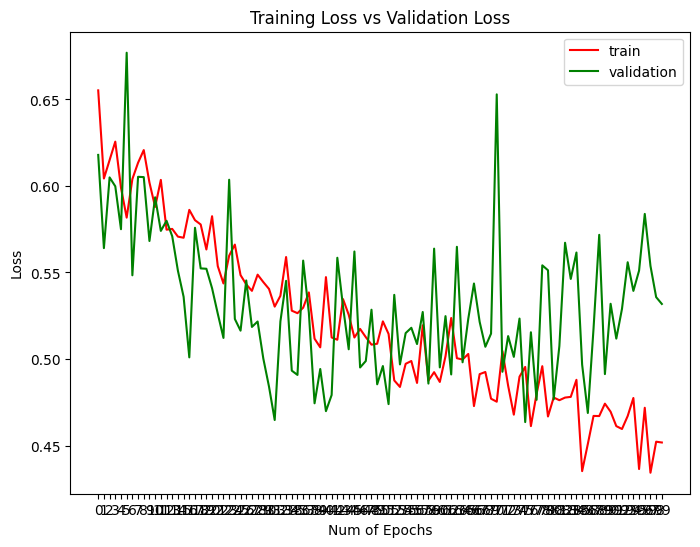

In [90]:
EPOCHS_USED=EPOCHS
plt.figure(0)
plt.plot(model_history.history['acc'],'r')
plt.plot(model_history.history['val_acc'],'g')
plt.xticks(np.arange(0, EPOCHS_USED, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(model_history.history['loss'],'r')
plt.plot(model_history.history['val_loss'],'g')
plt.xticks(np.arange(0, EPOCHS_USED, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

# plt.figure(2)
# plt.plot(model_history.history['F1'],'r')
# plt.plot(model_history.history['val_F1'],'g')
# plt.xticks(np.arange(0, EPOCHS_USED, 1.0))
# plt.rcParams['figure.figsize'] = (8, 6)
# plt.xlabel("Num of Epochs")
# plt.ylabel("F1 Score")
# plt.title("Training F1 vs Validation F1")
# plt.legend(['train','validation'])


plt.show()

In [30]:
model.metrics_names

['loss', 'acc', 'F1']

### Load best model

In [91]:
model = create_model()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 380, 508, 64)      4864      
                                                                 
 activation_28 (Activation)  (None, 380, 508, 64)      0         
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 76, 101, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 73, 98, 128)       131200    
                                                                 
 activation_29 (Activation)  (None, 73, 98, 128)       0         
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 18, 24, 128)       0         
 ng2D)                                               

In [92]:
model.load_weights('model-041-0.703125.h5')

In [94]:
loss_, acc_= model.evaluate(validation_generator)

3/3 [==============================] - 4s 1s/step - loss: 0.5275 - acc: 0.5714


In [97]:
print('-- Trained Model Evaluation --')
print(f'Loss : {loss_} , Accuracy : {acc_}')

-- Trained Model Evaluation --
Loss : 0.5274990797042847 , Accuracy : 0.5714285969734192


In [ ]:
# print('-- Loaded model Evaluation --')
# print(f'Loss : {loss_} , Accuracy : {acc_}, F1 Score : {F1_}' )
# -- Loaded model Evaluation --
# Loss : 0.4805612862110138 , Accuracy : 0.6428571343421936, F1 Score : 0.629019021987915

-- Loaded model Evaluation --
Loss : 0.4805612862110138 , Accuracy : 0.6428571343421936, F1 Score : 0.629019021987915


In [98]:
#https://stackoverflow.com/questions/43469281/how-to-predict-input-image-using-trained-model-in-keras

def load_image(img_path,img_height, img_width, show=False):

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])
        plt.axis('off')
        plt.show()

    return img_tensor

In [99]:
def print_prediction(pred):
  labels  = [ 'Appealing Color Constrast', 'Degree of minimalism', 'Visual Load']
  print('Image Evaluation Result : ')
  for i in range(len(labels)):
    print(f'{pred[0][i]} % of {labels[i]} ')

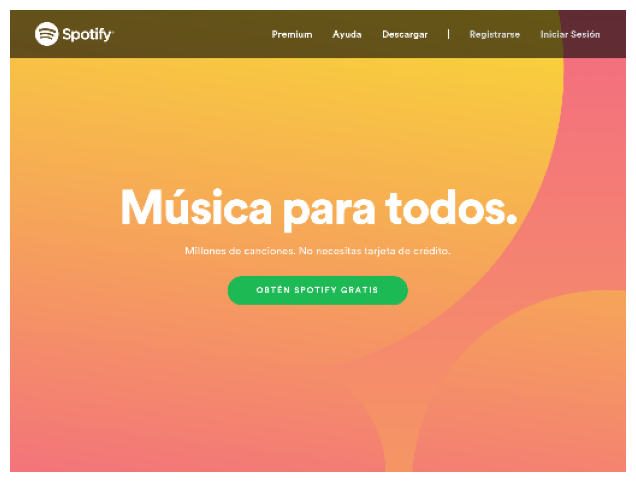

In [100]:
test_img_p = data_path_base + '/appealing_constrast/wss_419.png'
test_img = load_image(test_img_p, img_height,img_width,True)


In [101]:
pred = model.predict(test_img)
print(pred)
print_prediction(pred)

1/1 [==============================] - 0s 68ms/step
[[0.40176335 0.2878863  0.3338014 ]]
Image Evaluation Result : 
0.40176334977149963 % of Appealing Color Constrast 
0.28788629174232483 % of Degree of minimalism 
0.33380138874053955 % of Visual Load 


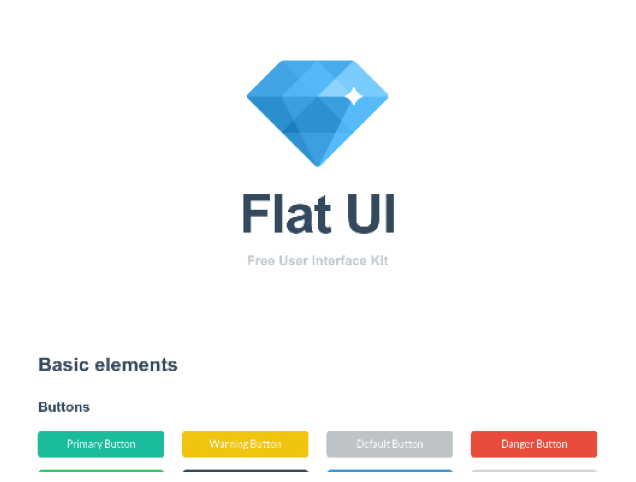

In [102]:
test_img_p = data_path_base + '/appealing_constrast/wss_447.png'
test_img = load_image(test_img_p, img_height,img_width,True)

In [103]:
pred = model.predict(test_img)
print(pred)
print_prediction(pred)

1/1 [==============================] - 0s 20ms/step
[[0.38448688 0.48306778 0.13237432]]
Image Evaluation Result : 
0.3844868838787079 % of Appealing Color Constrast 
0.4830677807331085 % of Degree of minimalism 
0.13237431645393372 % of Visual Load 


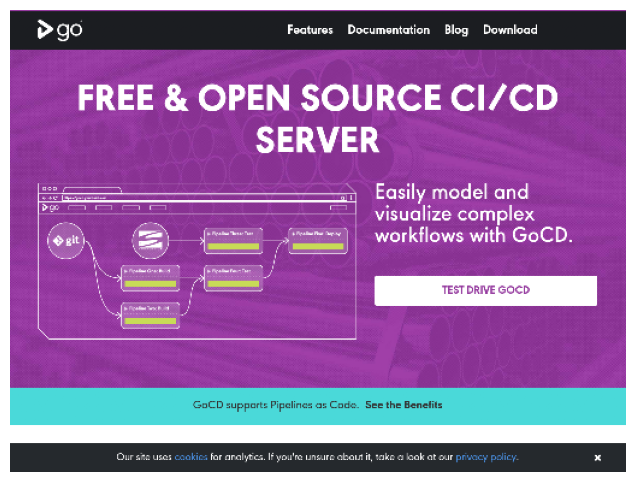

In [104]:
test_img_p =  data_path_base + '/visual_load/wss_100.png'
test_img = load_image(test_img_p, img_height,img_width,True)

In [105]:
pred = model.predict(test_img)
print(pred)
print_prediction(pred)

1/1 [==============================] - 0s 20ms/step
[[0.09392542 0.00154683 0.9926484 ]]
Image Evaluation Result : 
0.09392541646957397 % of Appealing Color Constrast 
0.0015468274941667914 % of Degree of minimalism 
0.9926484227180481 % of Visual Load 
